In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc

from torchtext import data
import spacy

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
input_rows = 20000
max_vocab = 5000

In [16]:
train_data = pd.read_json('./review20k/train.json', orient='records', lines=True)
val_data = pd.read_json('./review20k/val.json', orient='records', lines=True)
test_data = pd.read_json('./review20k/test.json', orient='records', lines=True)

C_list = [1, 10, 100, 1000, 1e4, 1e5]
gamma_list = [1e-3, 1e-2, .1, 1, 10, 100]

In [16]:
def svm_comments(text_train, label_train, text_val, label_val, C, gamma):
    vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=max_vocab, stop_words='english', lowercase=True)
    transformer = TfidfTransformer()
    x = transformer.fit_transform(vectorizer.fit_transform(text_train))
    val_x = transformer.transform(vectorizer.transform(text_val))
    
    label_train = [1 if l=='pos' else 0 for l in label_train]
    label_val = [1 if l=='pos' else 0 for l in label_val]
    clf = SVC(C=C, gamma=gamma)

    #scores = cross_val_score(clf, x, y, cv=5, scoring='accuracy')
    y_score = clf.fit(x, label_train).decision_function(val_x)
    fpr, tpr, _ = roc_curve(label_val, y_score)
    roc_auc = auc(fpr, tpr)
   
    return roc_auc

In [61]:
roc_auc_matrix = np.zeros((len(C_list), len(gamma_list)))
for i, C in enumerate(C_list):
    for j, gamma in enumerate(gamma_list):
        roc_auc_matrix[i,j] = svm_comments(train_data['text'], train_data['attitude'], val_data['text'], val_data['attitude'], C, gamma)
        print('C=%E, gamma=%E tested, ROC=%0.4f\n' % (C, gamma, roc_auc_matrix[i,j]))

KeyboardInterrupt: 

In [21]:
vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=max_vocab, stop_words='english', lowercase=True)
transformer = TfidfTransformer()
x = transformer.fit_transform(vectorizer.fit_transform(train_data['text']))
test_x = transformer.transform(vectorizer.transform(test_data['text']))

label_train = [1 if l=='pos' else 0 for l in train_data['attitude']]
label_test = [1 if l=='pos' else 0 for l in test_data['attitude']]
clf = SVC(C=10, gamma=1)

#scores = cross_val_score(clf, x, y, cv=5, scoring='accuracy')
y_score = clf.fit(x, label_train).decision_function(test_x)
fpr, tpr, _ = roc_curve(label_test, y_score)
roc_auc = auc(fpr, tpr)



NameError: name 'accuracy_score' is not defined

In [20]:
from sklearn.metrics import accuracy_score
print(accuracy_score(label_test, clf.predict(test_x)))



0.8975


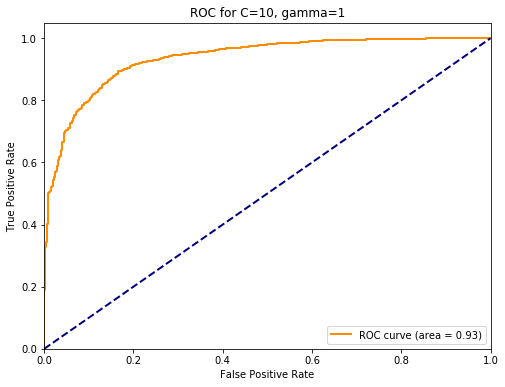

In [63]:
plt.figure(figsize=(8,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for C=10, gamma=1')
plt.legend(loc="lower right")
plt.show()

[Text(0, 0, '0.0001'),
 Text(0, 0, '0.001'),
 Text(0, 0, '0.01'),
 Text(0, 0, '0.1'),
 Text(0, 0, '1')]

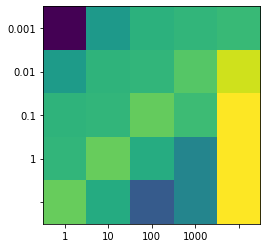

In [9]:
fig, ax = plt.subplots()
im = ax.imshow(roc_auc_matrix)
ax.set_xticklabels(C_list)
ax.set_yticklabels(gamma_list)


# Basic RNN trainning with torchtext 

In [34]:
TEXT = data.Field(tokenize = 'spacy')
LABEL = data.LabelField(dtype = torch.float)

In [35]:
# Load the training, validation and test data
train_data, val_data, test_data = data.TabularDataset.splits(
     path='review20k/', train='train.json',
     validation='val.json', test='test.json', format='json',
     fields={'text': ('text', TEXT),
            'attitude': ('attitude', LABEL)})

# Check data set size
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(val_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 12800
Number of validation examples: 3200
Number of testing examples: 4000


In [36]:
# build vocabulary for each set
TEXT.build_vocab(train_data, max_size = max_vocab)
LABEL.build_vocab(train_data)

print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 5002
Unique tokens in LABEL vocabulary: 2


In [37]:
# Define the dataloader for training/testing
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, val_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=lambda x: len(x.text),
    sort_within_batch=False)


In [38]:
# Define the RNN structure
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):

        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))
    


INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 592,105 trainable parameters


In [39]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

def binary_auc(preds, y):
    y_score = torch.sigmoid(preds)
    fpr, tpr, _ = roc_curve(y.cpu(), y_score.cpu())
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8,6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for C=1000, gamma=1')
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
                
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.attitude)
        
        acc = binary_accuracy(predictions, batch.attitude)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.attitude)
            
            acc = binary_accuracy(predictions, batch.attitude)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [40]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [41]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 7s
	Train Loss: 0.517 | Train Acc: 80.57%
	 Val. Loss: 0.495 |  Val. Acc: 81.69%
Epoch: 02 | Epoch Time: 0m 7s
	Train Loss: 0.490 | Train Acc: 80.64%
	 Val. Loss: 0.492 |  Val. Acc: 81.81%
Epoch: 03 | Epoch Time: 0m 7s
	Train Loss: 0.490 | Train Acc: 80.64%
	 Val. Loss: 0.490 |  Val. Acc: 82.00%
Epoch: 04 | Epoch Time: 0m 7s
	Train Loss: 0.491 | Train Acc: 80.64%
	 Val. Loss: 0.491 |  Val. Acc: 82.09%
Epoch: 05 | Epoch Time: 0m 7s
	Train Loss: 0.490 | Train Acc: 80.65%
	 Val. Loss: 0.490 |  Val. Acc: 82.28%
Epoch: 06 | Epoch Time: 0m 7s
	Train Loss: 0.489 | Train Acc: 80.63%
	 Val. Loss: 0.490 |  Val. Acc: 82.28%
Epoch: 07 | Epoch Time: 0m 7s
	Train Loss: 0.490 | Train Acc: 80.70%
	 Val. Loss: 0.489 |  Val. Acc: 82.28%
Epoch: 08 | Epoch Time: 0m 7s
	Train Loss: 0.491 | Train Acc: 80.66%
	 Val. Loss: 0.489 |  Val. Acc: 82.38%
Epoch: 09 | Epoch Time: 0m 7s
	Train Loss: 0.490 | Train Acc: 80.70%
	 Val. Loss: 0.489 |  Val. Acc: 82.44%
Epoch: 10 | Epoch Time: 0m 7

In [12]:
evaluate(model, test_iterator, criterion)

(0.5187806155946519, 0.7874503968253969)

# LSTM

In [7]:
class LSTMclf(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):

        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.lstm(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        #assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(output[-1,:,:])

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model = LSTMclf(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 867,049 trainable parameters


In [8]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

def binary_auc(preds, y):
    y_score = torch.sigmoid(preds)
    fpr, tpr, _ = roc_curve(y.cpu(), y_score.cpu())
    roc_auc = auc(fpr, tpr)

    return roc_auc

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
                
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.attitude)
        
        acc = binary_accuracy(predictions, batch.attitude)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.attitude)
            
            acc = binary_accuracy(predictions, batch.attitude)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [11]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 18s
	Train Loss: 0.573 | Train Acc: 80.66%
	 Val. Loss: 0.550 |  Val. Acc: 82.62%
Epoch: 02 | Epoch Time: 0m 18s
	Train Loss: 0.507 | Train Acc: 80.73%
	 Val. Loss: 0.521 |  Val. Acc: 82.94%
Epoch: 03 | Epoch Time: 0m 18s
	Train Loss: 0.494 | Train Acc: 80.69%
	 Val. Loss: 0.511 |  Val. Acc: 82.91%
Epoch: 04 | Epoch Time: 0m 18s
	Train Loss: 0.492 | Train Acc: 80.70%
	 Val. Loss: 0.507 |  Val. Acc: 82.91%
Epoch: 05 | Epoch Time: 0m 18s
	Train Loss: 0.490 | Train Acc: 80.67%
	 Val. Loss: 0.505 |  Val. Acc: 82.91%
Epoch: 06 | Epoch Time: 0m 18s
	Train Loss: 0.489 | Train Acc: 80.72%
	 Val. Loss: 0.504 |  Val. Acc: 82.94%
Epoch: 07 | Epoch Time: 0m 18s
	Train Loss: 0.490 | Train Acc: 80.67%
	 Val. Loss: 0.504 |  Val. Acc: 83.00%
Epoch: 08 | Epoch Time: 0m 18s
	Train Loss: 0.491 | Train Acc: 80.67%
	 Val. Loss: 0.504 |  Val. Acc: 83.00%
Epoch: 09 | Epoch Time: 0m 18s
	Train Loss: 0.490 | Train Acc: 80.70%
	 Val. Loss: 0.504 |  Val. Acc: 83.00%
Epoch: 10 | Epoch T

In [12]:
evaluate(model, test_iterator, criterion)

(0.527703258726332, 0.8129960317460317)